In [16]:
import pandas as pd
import os
import shutil
import tensorflow as tf

In [17]:
# Définition des chemins
csv_path = "/Users/maurice/Documents/certification/dermdetect/csv/dataset.csv"
image_dir = "/Users/maurice/Documents/data_nogit/Dermdetect/ALL"
sampled_image_dir = "/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20"
sample_csv_path = "/Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv"

# Charger le fichier CSV
df = pd.read_csv(csv_path)

# Normalisation des noms d'images (suppression des espaces et conversion en minuscules)
df['image_id'] = df['image_id'].str.strip().str.lower()

# Vérification des fichiers disponibles dans le dossier
files_in_directory = [f.lower() for f in os.listdir(image_dir)]

# Ajouter le chemin complet et filtrer les fichiers existants
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, x))
df = df[df['image_path'].apply(lambda x: os.path.basename(x) in files_in_directory)]

print(f"Nombre total d'images disponibles après correspondance : {len(df)}")

# Échantillonnage de 20 % avec une graine fixe pour reproductibilité
SAMPLE_SIZE = 0.20  # 20% des données
SEED = 42  # Graine fixe

df_sample = df.sample(frac=SAMPLE_SIZE, random_state=SEED)

print(f"Nombre d'images dans l'échantillon de 20% : {len(df_sample)}")

# Créer le dossier pour stocker l'échantillon si nécessaire
if not os.path.exists(sampled_image_dir):
    os.makedirs(sampled_image_dir)

# Copier les images sélectionnées dans le dossier d'échantillon
for _, row in df_sample.iterrows():
    src_path = row['image_path']
    dest_path = os.path.join(sampled_image_dir, os.path.basename(row['image_id']))
    shutil.copy(src_path, dest_path)

print(f"Les images de l'échantillon ont été copiées dans : {sampled_image_dir}")

# Sauvegarder l'échantillon dans un fichier CSV pour les étapes suivantes
df_sample[["image_id", "target"]].to_csv(sample_csv_path, index=False)

print(f"CSV de l'échantillon sauvegardé dans : {sample_csv_path}")


Nombre total d'images disponibles après correspondance : 72600
Nombre d'images dans l'échantillon de 20% : 14520
Les images de l'échantillon ont été copiées dans : /Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20
CSV de l'échantillon sauvegardé dans : /Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv


In [18]:
# Compter le nombre d'occurrences de chaque classe dans la colonne 'target'
target_counts = df['target'].value_counts()

# Affichage du nombre de 0 et de 1
target_counts

target
benign       37055
malignant    35545
Name: count, dtype: int64

In [19]:
# Compter le nombre d'occurrences de chaque classe dans l'échantillon
sample_target_counts = df_sample['target'].value_counts()

# Affichage du nombre de 0 et de 1 dans l'échantillon
sample_target_counts

target
benign       7423
malignant    7097
Name: count, dtype: int64

In [38]:
# Création du générateur d'images avec un split pour validation
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.3
)

In [39]:
# Générateur pour l'ensemble d'entraînement
train_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory='/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20',
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    shuffle = True,
    subset="training",
    seed= 42  # Graine pour reproductibilité
)

# Générateur pour l'ensemble de validation
val_generator = img_generator.flow_from_dataframe(
    dataframe=df_sample,
    directory='/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20',
    x_col="image_id",
    y_col="target",
    target_size=(128, 128),
    batch_size=32,
    shuffle =True,
    class_mode="binary",
    subset="validation",
    seed= 42  # Graine pour reproductibilité
)

# Vérification du nombre d'images dans chaque ensemble
print(f"Nombre d'images dans l'ensemble d'entraînement : {train_generator.samples}")
print(f"Nombre d'images dans l'ensemble de validation : {val_generator.samples}")

Found 10164 validated image filenames belonging to 2 classes.
Found 4356 validated image filenames belonging to 2 classes.
Nombre d'images dans l'ensemble d'entraînement : 10164
Nombre d'images dans l'ensemble de validation : 4356


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(128, 128, 3)),  # Définition explicite de la couche d'entrée

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(1, activation='sigmoid')
])

# Affichage de l'architecture avant la compilation
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,969 (515.50 KB)

 Trainable params: 131,969 (515.50 KB)

 Non-trainable params: 0 (0.00 B)

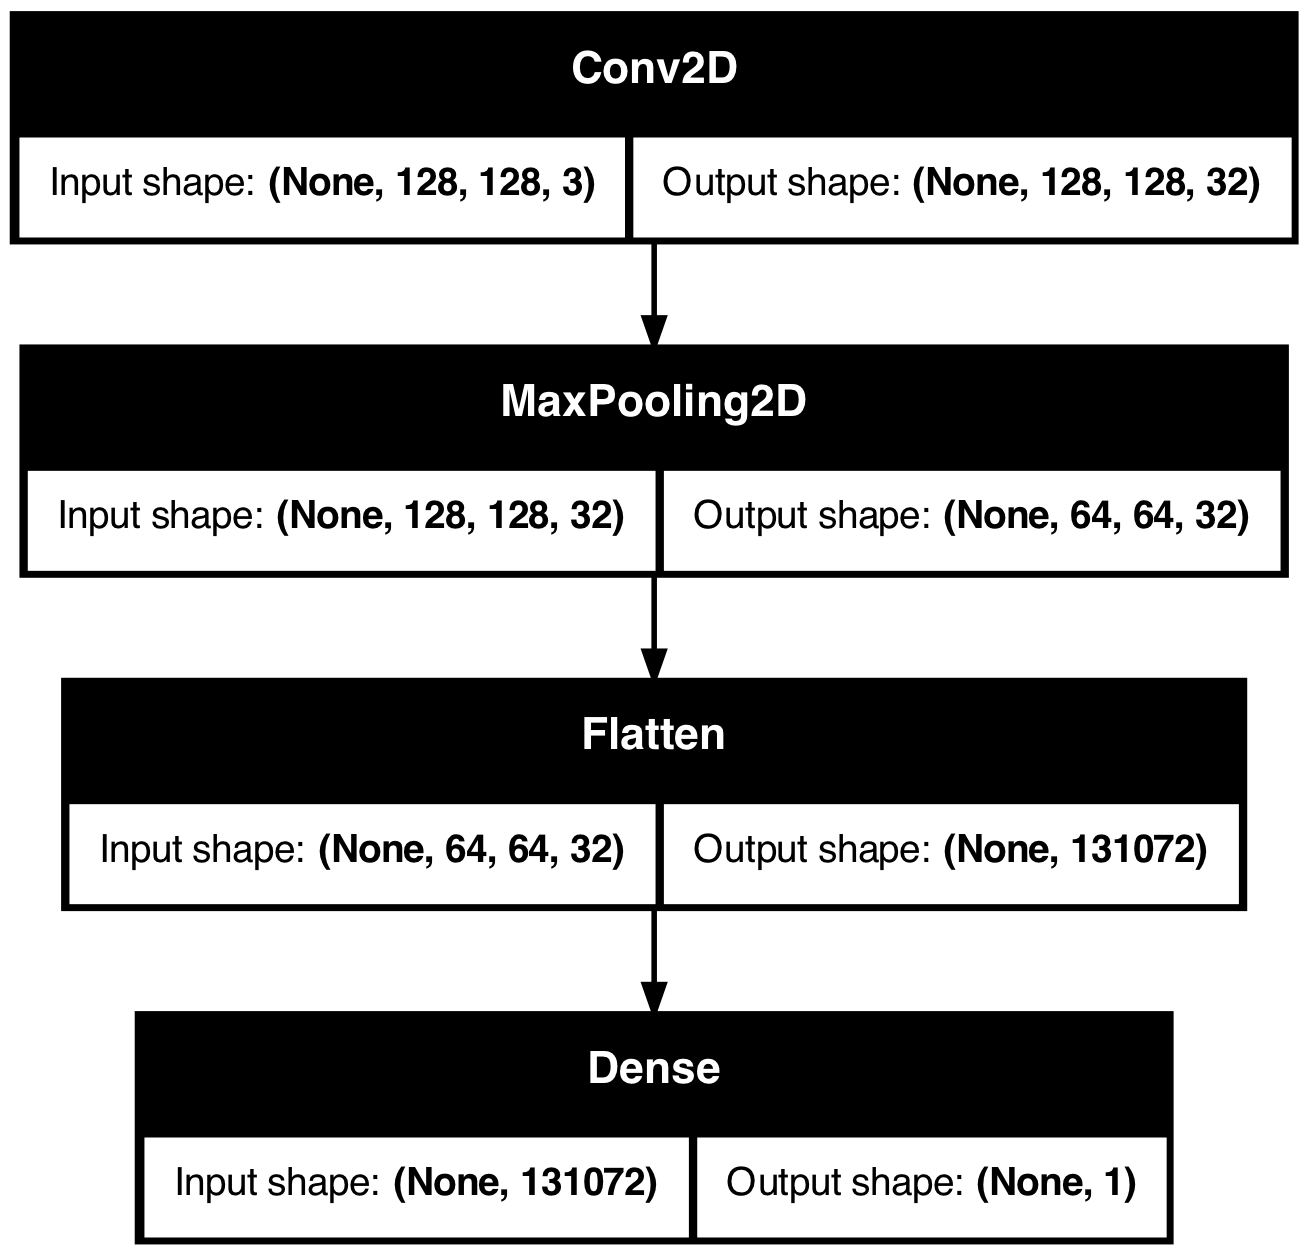

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [42]:
# Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)


In [43]:
history = model.fit(
    train_generator,     # Générateur des données d'entraînement
    epochs=13,           # Nombre d'époques
    validation_data=val_generator,  # Générateur des données de validation
    verbose=1            # Affichage des informations d'entraînement 
)

Epoch 1/13


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


318/318 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.6341 - auc: 0.6768 - loss: 0.7672 - val_accuracy: 0.7342 - val_auc: 0.8502 - val_loss: 0.5048
Epoch 2/13
318/318 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.7676 - auc: 0.8357 - loss: 0.5012 - val_accuracy: 0.8051 - val_auc: 0.8712 - val_loss: 0.4528
Epoch 3/13
318/318 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.7906 - auc: 0.8669 - loss: 0.4532 - val_accuracy: 0.8065 - val_auc: 0.8759 - val_loss: 0.4459
Epoch 4/13
318/318 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.7928 - auc: 0.8757 - loss: 0.4407 - val_accuracy: 0.7681 - val_auc: 0.8722 - val_loss: 0.4752
Epoch 5/13
318/318 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.8056 - auc: 0.8826 - loss: 0.4295 - val_accuracy: 0.8074 - val_auc: 0.8876 - val_loss: 0.4287
Epoch 6/13
318/318 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.8191 - auc: 0.9015 - loss: 0.3935 - val_accuracy: 0.7810 - val_auc: 0.8830 - val_loss: 0.4692
Epoch 7/13
318/318 ━━━━━━━━━━━━━━━━━━━━

In [44]:
model.save("baseline_cnn.h5")

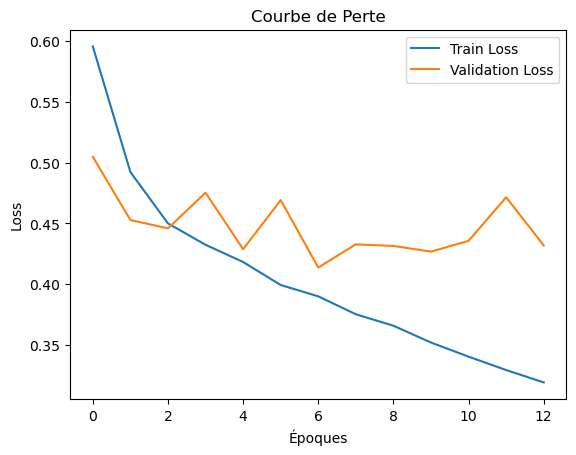

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Courbe de Perte")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.show()


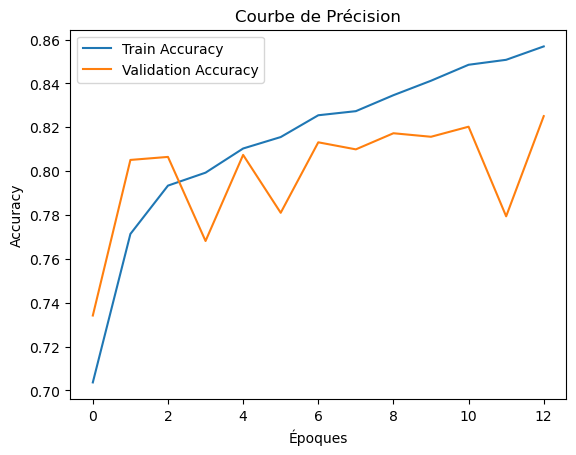

In [46]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Courbe de Précision")
plt.xlabel("Époques")
plt.ylabel("Accuracy")
plt.show()


In [47]:
val_loss, val_accuracy, val_auc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8293 - auc: 0.9026 - loss: 0.4109
Validation Loss: 0.4318
Validation Accuracy: 0.8251
Validation AUC: 0.8971


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Prédictions sur l'ensemble de validation
y_true = val_generator.classes  # Les vraies classes
y_pred = (model.predict(val_generator) > 0.5).astype("int32")  # Seuil de décision 0.5

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("Matrice de confusion:")
print(cm)

# Rapport de classification
print("Rapport de classification:")
print(classification_report(y_true, y_pred))


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
Matrice de confusion:
[[ 936 1239]
 [ 889 1292]]
Rapport de classification:
              precision    recall  f1-score   support

           0       0.51      0.43      0.47      2175
           1       0.51      0.59      0.55      2181

    accuracy                           0.51      4356
   macro avg       0.51      0.51      0.51      4356
weighted avg       0.51      0.51      0.51      4356



array([[ 936, 1239],
       [ 889, 1292]])

In [50]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import confusion_matrix

# Vraies classes
y_true = val_generator.classes  

# Prédictions du modèle
y_pred = (model.predict(val_generator) > 0.5).astype("int32")  

# Calcul de la matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Création d'un DataFrame pour Plotly
df_cm = pd.DataFrame(
    cm, 
    index=['Bénin', 'Malin'],  # Noms des vraies classes
    columns=['Bénin', 'Malin']  # Noms des prédictions
)

# Création de la heatmap interactive avec Plotly Express
fig = px.imshow(df_cm, 
                text_auto=True,  # Affiche les valeurs dans la matrice
                color_continuous_scale='Blues',  # Palette de couleurs
                labels=dict(x="Prédictions", y="Vraies Classes", color="Nombre d'occurrences")
)

# Personnalisation des axes
fig.update_xaxes(title="Prédictions")
fig.update_yaxes(title="Vraies Classes")

# 


137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


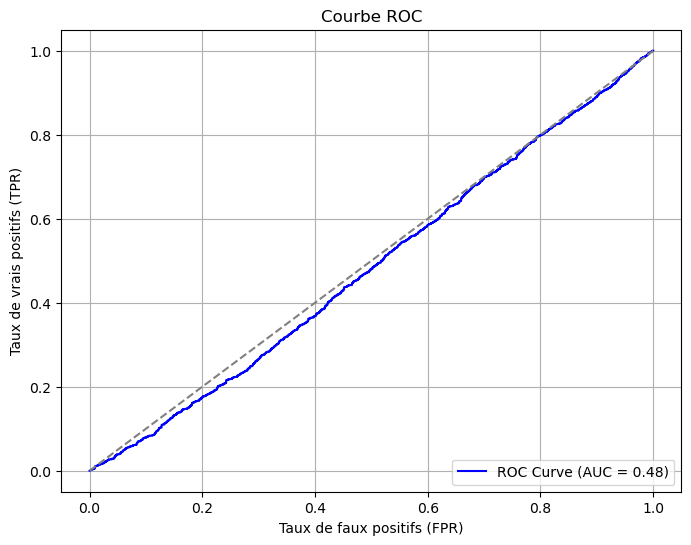

Seuil optimal basé sur le point de coude : 0.0069


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtenir les vraies valeurs (ground truth)
y_true = val_generator.classes  

# Prédictions sous forme de probabilités (pour la classe positive "1")
y_pred_prob = model.predict(val_generator).ravel()

# Calcul des valeurs de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Ligne de référence
plt.title('Courbe ROC')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Trouver le point optimal (point de coude)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Seuil optimal basé sur le point de coude : {optimal_threshold:.4f}")


In [ ]:
E